In [1]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az

from gensim import corpora
from gensim.models import LdaModel

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Q1

In [3]:
# DO NOT MODIFY THIS CODE
website_visits_data = np.loadtxt('https://raw.githubusercontent.com/MIE223-2024/course-datasets/main/website_visits.csv', delimiter=',')

## (a)

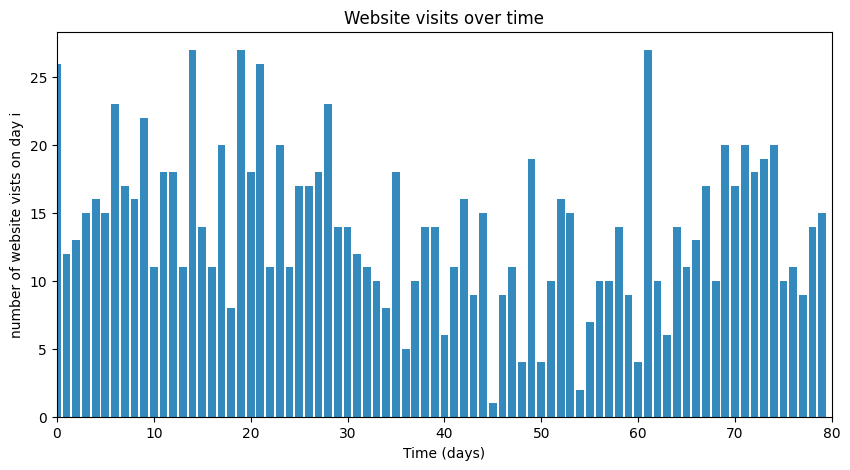

In [4]:
# YOUR CODE STARTS HERE
# Q1a - Plot a bar chart (not a histogram) of the count of website visits per day

num_visits = len(website_visits_data)

plt.figure(figsize=(10,5))
plt.bar(np.arange(num_visits), website_visits_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("number of website vists on day i")
plt.title("Website visits over time")
plt.xlim(0, num_visits);


**Enter your answer here:**

It seems that the number of website visits dropped after 30/40+ days. Website visits then increased after 60/70 + days. These could possibly signify switchpoints in the data.

## (b)

In [5]:
# DO NOT MODIFY THIS CODE

param_names = ['tau_1', 'tau_2', 'lambda_1', 'lambda_2', 'lambda_3']

double_switchpoint_model = pm.Model()

with double_switchpoint_model:

  # Define priors
  # YOUR CODE STARTS HERE (FILL IN THE BLANKS)
  alpha = 1/np.mean(website_visits_data)
  tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper= 79)
  tau_2 = pm.DiscreteUniform("tau_2", lower=0, upper= 79)
  lambda_1 = pm.Exponential("lambda_1", alpha)
  lambda_2 = pm.Exponential("lambda_2", alpha)
  lambda_3 = pm.Exponential("lambda_3", alpha)
  idx = np.arange(num_visits)
  lambda_12 = pm.math.switch(idx < tau_1, lambda_1, lambda_2)
  lambda_ = pm.math.switch(idx < tau_2, lambda_12, lambda_3)

  # Define likelihood (conditioned on observed data)

  # YOUR CODE STARTS HERE (FILL IN THE BLANK)
  likelihood = pm.Poisson("visits", lambda_,observed = website_visits_data)

  # Sample from posterior
  # YOUR CODE STARTS HERE (FILL IN THE BLANK)
  trace = pm.sample(1000,random_seed = 45)

## (c)

In [6]:
# Function to: (a) plot histogram of posterior samples (b) display mean and 94% HDI of posterior samples

def plot_posterior(param_name, trace):

    # (a) Plot histogram of posterior samples of passed parameter
    # YOUR CODE STARTS HERE

  ax = sns.histplot(trace.posterior[param_name].values.flatten())
  ax.set_xlim(0, num_visits)
  plt.xlabel(param_name)
  plt.ylabel('Number of Samples')
  plt.title('Histogram of Posterior Samples of ' + str(param_name))

    # (b) Display mean and 94% HDI of posterior samples of passed parameter (round to 2 decimal places)
    # YOUR CODE STARTS HERE

  print(f"\nMean of {param_name}: {np.mean(trace.posterior[param_name].values.flatten())}")
  hdi = az.hdi(trace.posterior[param_name].values.flatten())
  print(f"94% HDI of {param_name}: {hdi}")

  # got curly braces from :
  #https://discovery.cs.illinois.edu/guides/Python-Fundamentals/brackets/

  return None


Mean of tau_1: 50.7435
94% HDI of tau_1: [22 76]


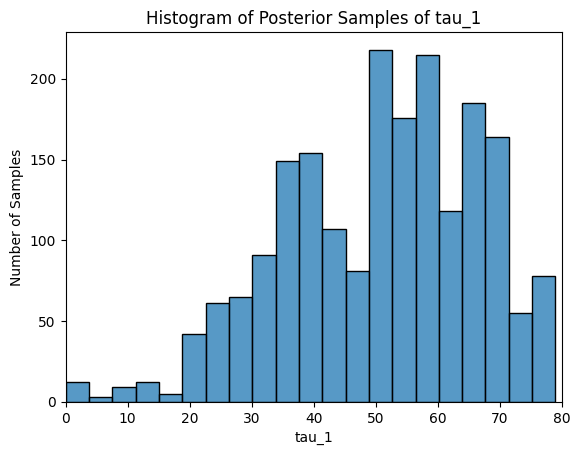


Mean of tau_2: 29.7645
94% HDI of tau_2: [27 33]


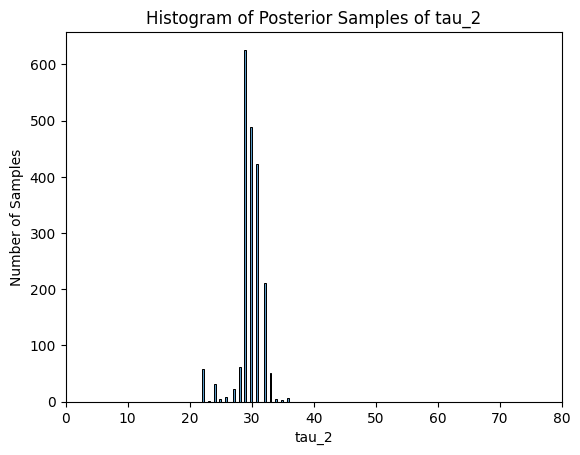


Mean of lambda_1: 17.098343652400036
94% HDI of lambda_1: [15.62738205 18.42165738]


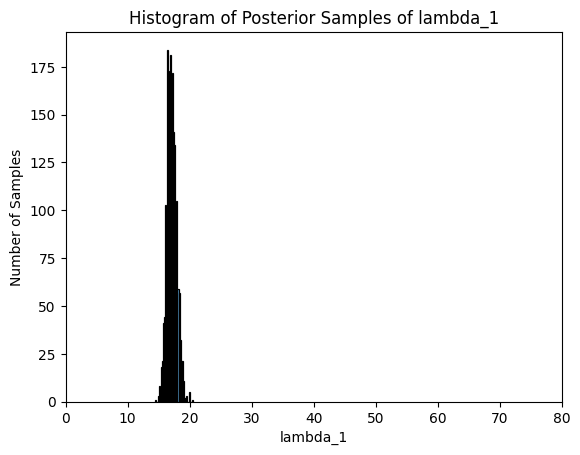


Mean of lambda_2: 13.697108160073366
94% HDI of lambda_2: [1.67208128e-03 3.70375633e+01]


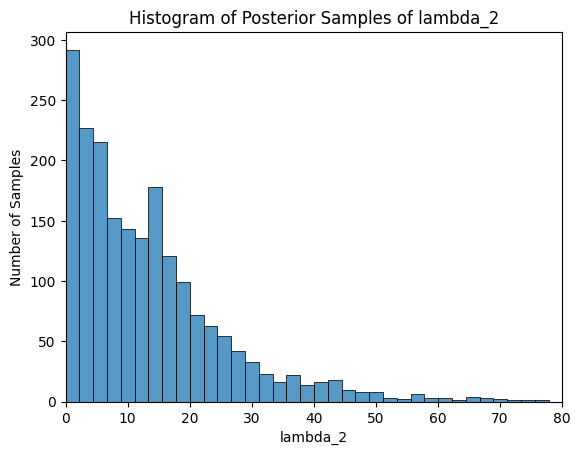


Mean of lambda_3: 12.046920571124968
94% HDI of lambda_3: [11.08642295 12.9141061 ]


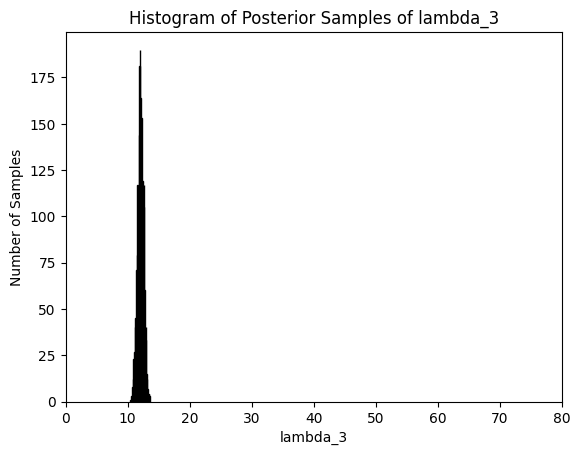

In [7]:
# DO NOT MODIFY THIS CODE
for param_name in param_names:
    plot_posterior(param_name, trace)
    plt.show()

**Enter answer here:**

The current model is not a good fit. While lamba 1 and 3 have narrow 94% HDI's,
lambda 2 has a large 94% HDI which is indicative of bad model choices. The histograms of the posterior samples do not align with my expectations observed in part a since the histogram for tau_1 indicate that there is a switchpoint between 22 and 76 and tau_2 indicates there is a switchpoint between 27 and 33. However the observed trends indicate switchpoints betwwen 30/40 and 60/70.




## (d)

In [8]:
# DO NOT MODIFY THIS CODE

double_switchpoint_model_adjusted = pm.Model()

with double_switchpoint_model_adjusted:

  # Define priors
  # YOUR CODE STARTS HERE

  alpha = 1/np.mean(website_visits_data)
  tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper= 79)
  tau_2 = pm.DiscreteUniform("tau_2", lower= tau_1 + 1, upper= 79)
  lambda_1 = pm.Exponential("lambda_1", alpha)
  lambda_2 = pm.Exponential("lambda_2", alpha)
  lambda_3 = pm.Exponential("lambda_3", alpha)
  idx = np.arange(num_visits)
  lambda_12 = pm.math.switch(idx < tau_1, lambda_1, lambda_2)
  lambda_ = pm.math.switch(idx < tau_2, lambda_12, lambda_3)

  # Define likelihood (conditioned on observed data)
  # YOUR CODE STARTS HERE
  likelihood = pm.Poisson("visits", lambda_,observed = website_visits_data)

  # Sample from posterior
  # YOUR CODE STARTS HERE
  trace_adjusted = pm.sample(1000,random_seed = 45)

**Enter your answer here:**

Both tau_1 and tau_2 could have values from 0 to 79. However if we do this, then tau_1 could have a HDI range greater than tau_2 which may cause a hyperprior. Thus, we can set the bounds for tau_2 to be between tau_1 + 1 and 79 instead.

## (e)


Mean of tau_1: 30.687
94% HDI of tau_1: [29 33]


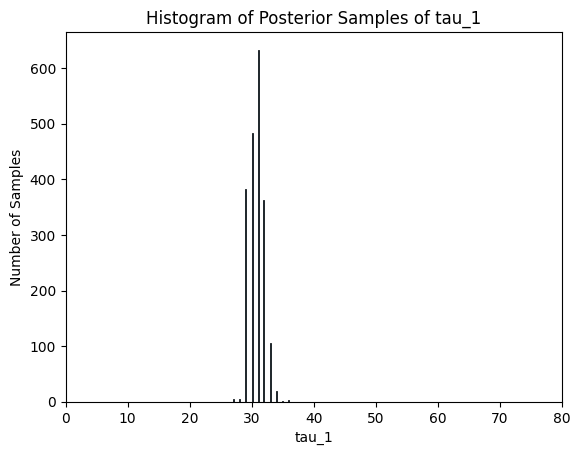


Mean of tau_2: 63.0095
94% HDI of tau_2: [60 68]


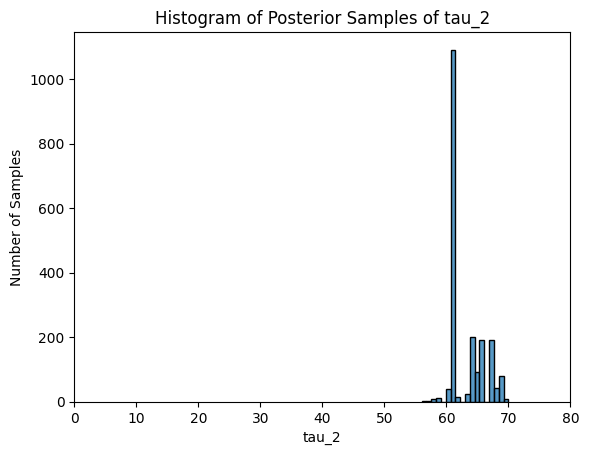


Mean of lambda_1: 17.06385218204822
94% HDI of lambda_1: [15.69480867 18.4503709 ]


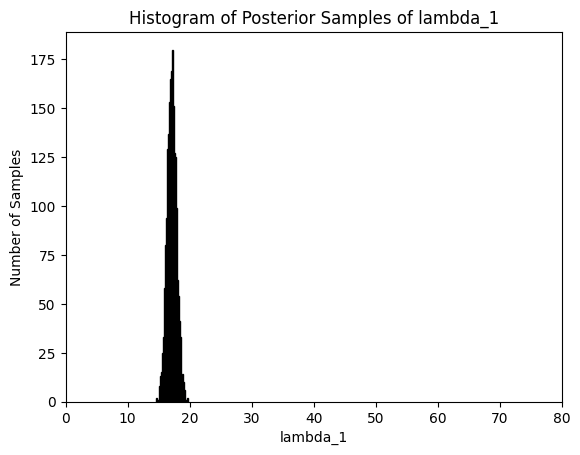


Mean of lambda_2: 10.43225281058766
94% HDI of lambda_2: [ 9.28130353 11.53951208]


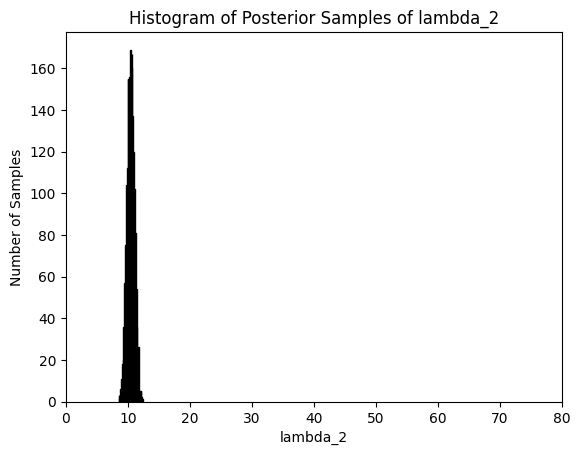


Mean of lambda_3: 14.923615504079933
94% HDI of lambda_3: [13.08789866 16.68663448]


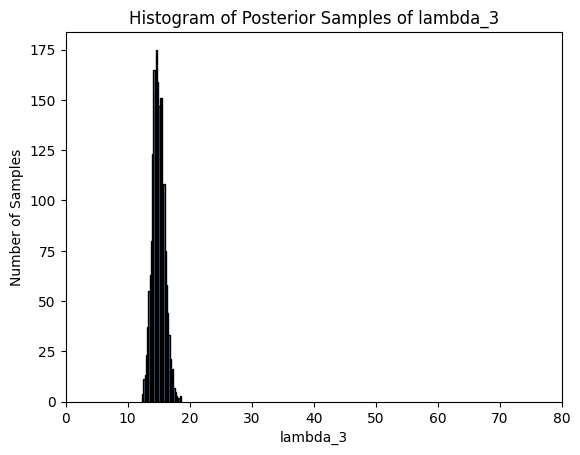

In [9]:
# YOUR CODE GOES HERE
for param_name in param_names:
    plot_posterior(param_name, trace_adjusted)
    plt.show()





**Enter answer here:**

The current model is a good fit as all lambda 1,2 and 3 all have narrow 94% HDI ranges. The posterior sample histograms do align with my expectations since they indicate that the switchpoints occur at ~ 29-63 and ~ 60-68 which are in the 30-40 and 60-70 ranges I saw from the observed trends.

# Q2

In [10]:
topic_df = pd.read_csv('https://raw.githubusercontent.com/MIE223-2024/course-datasets/main/topic_dataset.csv')
topic_df["preprocessed"] = topic_df["preprocessed"].apply(lambda x: ast.literal_eval(x))
topic_df.head()

,document,preprocessed
0,Hi Xperts!\n\nHow can I move the cursor with t...,"[xperts, cursor, keyboard, cursor, key, mouse,..."
1,Where can I obtain a copy of the Open Look wid...,"[obtain, copy, open, look, widget, obtainable,..."
2,\nYou're right about the signal being strong. ...,"[right, signal, strong, live, west, philadelph..."
3,"\nHe's a Canadian ""thing"". Former coach of the...","[canadian, thing, coach, boston, bruin, colora..."
4,"\n\n Heck, I seem to feel like that *ev...","[heck, feel, like, time, including, cafeteria,..."


## (a)

In [11]:
## YOUR CODE GOES HERE

# Build the id2word dictionary and the corpus (map the word to id)
texts = topic_df['preprocessed']
dictionary = corpora.Dictionary(texts)
print('Number of unique tokens: ', len(dictionary))

# Remove stop words from a stop words set; merged from nltk and scikit-learn's built-in list and words
stoplist = set(stopwords.words('english')).union(set(ENGLISH_STOP_WORDS))
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist
            if stopword in dictionary.token2id]
dictionary.filter_tokens(stop_ids)

# Filter out words that appear in less than 2 documents (appear only once)
# There's also a no_above argument that we could specify, e.g. no_above = 0.5 would remove words that appear in more than 50% of the documents
dictionary.filter_extremes(no_below = 2)
dictionary.filter_extremes(no_above= 0.5)

# Remove gaps in id sequence after words that were removed
dictionary.compactify()
print('Number of unique tokens: ', len(dictionary))

# Convert words to the "learned" word id
corpus = [dictionary.doc2bow(text) for text in texts]


Number of unique tokens:  49388
Number of unique tokens:  12325


## (b)

In [12]:
# Train LDA model

# YOUR CODE GOES HERE
# Training LDA can take some time, set eval_every = None to not evaluate the model perplexity
topic_model = LdaModel(corpus, id2word = dictionary, num_topics = 10, iterations = 100, eval_every = None, random_state = 100, minimum_probability = 0)



In [13]:
# Display LDA visualization

# YOUR CODE GOES HERE
lda_topic_diagram = pyLDAvis.gensim_models.prepare(topic_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_topic_diagram)
lda_topic_diagram


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.098355 -0.008029       1        1  17.307905
1     -0.183558 -0.107652       2        1  10.126147
2      0.012400  0.163457       3        1   5.405787
3     -0.050902  0.030655       4        1   7.410404
4      0.085787  0.043409       5        1   4.848732
5     -0.055921  0.036867       6        1   9.956483
6     -0.121706 -0.049556       7        1  13.659480
7      0.014280  0.035179       8        1  11.075134
8      0.005995 -0.002908       9        1  14.641401
9      0.195271 -0.141422      10        1   5.568527, topic_info=            Term         Freq        Total Category  logprob  loglift
126         game  2219.000000  2219.000000  Default  30.0000  30.0000
633     armenian  1763.000000  1763.000000  Default  29.0000  29.0000
3022        bike   755.000000   755.000000  Default  28.0000  28.0000
88          team  1462.000000  1462.000000  Default  27.0000  27.0000
1539         jew   616.000000   616.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1614  university   138.175798   712.182357  Topic10  -5.5859   1.2482
2045    american   134.594642   656.039406  Topic10  -5.6121   1.3041
1027      series   127.948482   453.797538  Topic10  -5.6628   1.6220
50          home   135.290813   748.857998  Topic10  -5.6070   1.1769
1536        arab   126.724869   676.042773  Topic10  -5.6724   1.2138

[873 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
5961       5  0.922241       abbott
2379       9  0.981170      abiding
9707       2  0.911000  accelerator
9707       5  0.050611  accelerator
9707       9  0.016870  accelerator
...      ...       ...          ...
2275       7  0.022187         york
2275       8  0.019414         york
2275       9  0.030508         york
2275      10  0.585191         york
10394      9  0.959949         zoom

[3698 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

## (c)

**Enter answer here:**

Topic 7 top 5 salient words: space, window, information, program, data.
Topic 7 also contains words like nasa and shuttle, therefore Topic 7 most likely relates to space technology.

Topic 3 top 5 salient words: bike, like, good, think, road.
Topic 3 also contains words like istanbul and motorcycle, therefore Topic 3 likely relates to travelling.

Topic 6 top 5 salient words: diesease, patient, medical, health, problem.
Topic 6 also contains words like cancer and treatment, thus Topic 6 most likely relates to Healthcare.
